# APS Lab 2: Finding Position with Linear Least Squares

### EECS16A: Designing Information Devices and Systems I, Fall 2021

<!------ Developed by Phil Sandborn, Seiya Ono, Linda Du ------>

# Table of Contents

* [Instructions](#instructions)
* [Lab Policies](#policies)
* [Introduction](#intro)
* [Task 0: Imports](#task0)
* [Multilateration](#multilateration)
* [Task 1: Constructing the System of Equations](#task1)
* [Task 2: Using Least Squares](#task2)
* [Task 3: Simulation Testing](#task3)
* [Task 4: Real Life Positioning](#task4)

<a id='instructions'></a>
## Instructions
* Complete this lab by filling in all of the required sections, marked with `"YOUR CODE HERE"` or `"YOUR COMMENTS HERE"`.
* When you finish, submit a checkoff request to get checked off for this lab. Be ready to answer a few questions to show your understanding of each section.
* Labs will be graded based on completion for teams of 2-4 students.

<a id='policies'></a>
## Lab Policies
* **YOU MUST ATTEND THE LAB SECTION YOU ARE ENROLLED IN. If you anticipate missing a section, please notify your GSI in advance.**
* **You are free to stay for the full allotted time and hack around with the lab setup or code, but please reserve the GSI's time for lab-related questions.**
* **Keep food and drinks away from your devices / equipment.**

<a id='intro'></a>
## Introduction

**<span style="color:red">
If you have not completed APS 1 yet, you must complete it first, or this lab will not make any sense. You can then complete APS 2 during the next and final buffer lab.
</span>**

In the last lab we introduced the signal processing part for our lab and obtained the TDOA's (Time Difference Of Arrivals) of different beacon signals. This week we are going to explore methods that help us determine the final position.

<a id='task0'></a>
# <span style="color:blue">Task 0: Imports</span>

In [1]:
%pylab inline
%run -i support_code/APS.py
%run support_code/helper_functions.py

Populating the interactive namespace from numpy and matplotlib


<a id='multilateration'></a>
# Multilateration

Multilateration is a technique sometimes used in positioning systems to precisely locate a receiver by measuring the time difference of arrivals (TDOAs) from several synchronized *beacons* at one receiver location.

Consider the APS 2 Lab slides:

Suppose we have $N$ beacons $\vec{a}_0,~\vec{a}_1,~\cdots,~\vec{a}_{N - 1}$, so the position of a beacon $\vec{a}_i$ in the 2-D plane will be $\vec{a}_i = [a_{i,x}, a_{i ,y}]^T$. These positions are known. We also have a receiver $\vec{r}$ with unknown position $\vec{r}=[r_x, r_y]^T$ in the same plane. Let $d_i$ denote the distance of $a_i$ to $\vec{r}$, $d_i = \sqrt{(r_x - a_{i, x})^2 + (r_y - a_{i, y})^2}$. 

For simplification, in this lab we use beacon 0 as a reference placed at the origin, i.e., $\vec{a}_0 = [a_{0,x}, a_{0 ,y}]^T = [0, 0]^T$. We also let $\tau_0$, $\tau_1$ ... $\tau_{n - 1}$ denote the TDOA's. Since we are referencing all the beacons to beacon 0, we also define $\Delta\tau_m = \tau_m - \tau_0 $. 

Recall from last week that we found the distances from speakers to the microphone by assuming a known arrival time of beacon 0, $\tau_0$. However in a real application like GPS, where the beacons and the receiver are not synchronous, we also need to estimate $\tau_0$. 

From $M$ number of beacons, we have $M$ equations for $0\leq i<M$:
$$ \Vert \vec{r}- a_i \Vert ^2 = d_i^2 $$

Expanding the norm, and substituting for $d_i=v_s\tau_i$ where $v_s$ is the speed of sound, we get:

---
$$ \Vert \vec{r} \Vert^2 - 2\vec{a}_i^T\vec{r} + \Vert \vec{a}_i \Vert^2 = v_s^2\tau_i^2 $$

We can get rid of the quadratic term $\Vert \vec{r} \Vert^2$ by subracting each $i^\mathrm{th}$ equation with the first equation ($i=0$):

---

$$ 2(\vec{a}_0-\vec{a}_i)^T\vec{r} = \Vert \vec{a}_0 \Vert^2 - \Vert \vec{a}_i \Vert^2 + v_s^2(\tau_i^2-\tau_0^2) $$

Expanding $\tau_i^2-\tau_0^2 =  (\tau_i-\tau_0)(\tau_i+\tau_0)  =  (\tau_i-\tau_0)(\tau_i-\tau_0+2\tau_0) = \Delta\tau_i (\Delta \tau_i + 2\tau_0)$ we express the argument in terms of the measured time differences $\Delta \tau_i$ and the unknown $\tau_0$, and get:

___

$$ 2(\vec{a}_0-\vec{a}_i)^T\vec{r} = \Vert \vec{a}_0 \Vert^2 - \Vert \vec{a}_i \Vert^2 + v_s^2\Delta \tau_i(\Delta \tau_i + 2\tau_0) $$

Rearranging, we get a linear set of equation w.r.t $\vec{r}$ and $\tau_0$!

---

$$ 2(\vec{a}_0-\vec{a}_i)^T\vec{r} - 2(v_s^2\Delta \tau_i)\tau_0 = \Vert \vec{a}_0 \Vert^2 - \Vert \vec{a}_i \Vert^2 + v_s^2\Delta \tau_i^2 $$

And explicitly for the variables $r_x,~r_y,~\tau_0$, and substituting $\vec{a}_0 = [0,0]^T$:

---

$$ -2a_{i,x}r_{x} - 2a_{i,y}r_y - 2v_s^2\Delta \tau_i \tau_0 = -a_{i,x}^2 - a_{i,y}^2 + v_s^2 \Delta \tau_i^2 $$

Negating we get the final result 

---

$$ 2a_{i,x}\color{red}{r_{x}} + 2a_{i,y}\color{red}{r_y} + 2v_s^2\Delta \tau_i \color{red}{\tau_0} = a_{i,x}^2  +a_{i,y}^2 - v_s^2 \Delta \tau_i^2 $$

which are $M-1$ equations (since we used equation $i=0$), for $1\leq i < M$.

Below is the same equation written out as a matrix for a system that has $M$ speakers. $r_x$ and $r_y$ are the coordinates of your speaker that you would like to solve for, and $\tau_0$ is the arrival time of beacon 0.

$$ 2 \left [
\begin{matrix}
    a_{1,x}  & a_{1,y} & v_s^2\Delta \tau_1 \\
    a_{2,x}  & a_{2,y} & v_s^2\Delta \tau_2 \\
    &\vdots & \\
    a_{M-1,x}  & a_{M-1,y} & v_s^2\Delta \tau_{M-1}
\end{matrix}
\right] 
\left [
\begin{matrix} 
    r_x\\ r_y \\ \tau_0
\end{matrix}
\right]
=
\left [
\begin{matrix}
    a_{1,x}^2  +a_{1,y}^2 - v_s^2 \Delta \tau_1^2 \\
    a_{2,x}^2  +a_{2,y}^2 - v_s^2 \Delta \tau_2^2 \\
    \vdots  \\
    a_{M-1,x}^2  +a_{M-1,y}^2 - v_s^2 \Delta \tau_{M-1}^2
\end{matrix}
\right]
$$


**<span style="color:red">
What is the minimum number of beacons we need in order to be able to recover a position from our system?
</span>**

**`YOUR ANSWER HERE`** \
**At least three beacons are required to define the position in 2D**

<img src="img/plot_speakers_demo.png" align="left" style="height:500px" />      

As we see in the above example, the microphone's position lies on the intersection of the curves. Finding the position of the microphone is equivalent to finding the solution for the linear system.

**<span style="color:red">
Is our actual positioning system setup in this lab overdetermined or underdetermined? You may want to look at the presentation for APS 2 on the course website for a picture of the setup. Is this good or bad?
</span>**

**`YOUR ANSWER HERE`**

<a id='task1'></a>
# <span style="color:blue">Task 1: Constructing the System of Equations</span>

Once we find the equations for each speaker and the microphone, we are able to construct a system of linear equations.

**<span style="color:red"> Write the function below that sets up the least squares problem. While the code block is large and may seem complex, the portions that you have to fill in are much simpler. If you find yourself stuck, try fulfilling the exact requirements of the prompt you are working on, while ignoring the others.</span>**

For your convenience, the matrix equation is copied here:

$$ 2 \left [
\begin{matrix}
    a_{1,x}  & a_{1,y} & v_s^2\Delta \tau_1 \\
    a_{2,x}  & a_{2,y} & v_s^2\Delta \tau_2 \\
    &\vdots & \\
    a_{M-1,x}  & a_{M-1,y} & v_s^2\Delta \tau_{M-1}
\end{matrix}
\right] 
\left [
\begin{matrix} 
    r_x\\ r_y \\ \tau_0
\end{matrix}
\right]
=
\left [
\begin{matrix}
    a_{1,x}^2  +a_{1,y}^2 - v_s^2 \Delta \tau_1^2 \\
    a_{2,x}^2  +a_{2,y}^2 - v_s^2 \Delta \tau_2^2 \\
    \vdots  \\
    a_{M-1,x}^2  +a_{M-1,y}^2 - v_s^2 \Delta \tau_{M-1}^2
\end{matrix}
\right]
$$



**Note: The array `TDOA` is an array of $\Delta\tau_m$ values.**

In [23]:
def construct_system(speakers, TDOA, v_s):
    """Construct the components of the system according to a list of TDOAs and speaker coordinates
    Args:
    speakers (np.array): an array of speaker coordinate tuples 
    TDOA (np.array): an array of **relative** TDOA's
    
    Returns:
    A (np.array): the matrix corresponding to the least squares system
    b (np.array): the vector corresponding to the least squares system
    
    """
    
    # create an empty GxH matrix using np.zeros
    # G is the number of rows in matrix A (num_beacons - 1), and H is the number of unknowns
    G = speakers.shape[0]-1
    H = 3 # Enter number of unknowns here
    A = np.zeros((G,H))
    
    # create an empty Gx1 vector using np.zeros
    b = np.zeros((G,1))
    
    # Loop to enter values into matrix A and vector B, one row at a time
    # **Remember**: The first row of matrix A (i = 0) uses values corresponding to beacon 1.
    #               This affects how you index into speakers and TDOA. 
    for i in range(G):
        
        # fill in the first column
        A[i,0] = speakers[i + 1, 0] * 2 # YOUR CODE HERE
        
        # fill in the second column
        A[i,1] = speakers[i + 1, 1] * 2 # YOUR CODE HERE
        
        # fill in the 3rd column
        A[i,2] = v_s**2 * (TDOA[i+1] - TDOA[0]) * 2 # YOUR CODE HERE
        
        # fill in the values for b
        b[i] = speakers[i + 1, 0]**2 + speakers[i + 1, 1]**2 - (v_s**2)* ((TDOA[i+1] - TDOA[0])**2) # YOUR CODE HERE
        
    return np.array(A), np.array(b)

Take a look at your results and make sure it works correctly (Don't worry if there are some small errors on order of +/- 0.5):

In [24]:
construct_system_test(construct_system)

Row 0: 23 should equal 23. Test passed.
Row 1: 21 should equal 21. Test passed.
Row 2: 50 should equal 50. Test passed.
Row 3: 2 should equal 2. Test passed.
Row 4: 6 should equal 6. Test passed.

Your A matrix:
[[   10.             0.           982.04499441]
 [    0.            10.         -1328.64911008]
 [   10.            10.           173.30205784]
 [    0.             5.         -1475.69328037]
 [    5.             0.            26.25788755]]
Reference A matrix:
[[   10.             0.           982.04499441]
 [    0.            10.         -1328.64911008]
 [   10.            10.           173.30205784]
 [    0.             5.         -1475.69328037]
 [    5.             0.            26.25788755]]

Your b vector:
[[22.91788646]
 [21.18879564]
 [49.93515909]
 [ 1.54852821]
 [ 6.24851146]]
Reference b vector:
[22.91788646 21.18879564 49.93515909  1.54852821  6.24851146]


$$ 2 \left [
\begin{matrix}
    a_{1,x}  & a_{1,y} & v_s^2\Delta \tau_1 \\
    a_{2,x}  & a_{2,y} & v_s^2\Delta \tau_2 \\
    &\vdots & \\
    a_{M-1,x}  & a_{M-1,y} & v_s^2\Delta \tau_{M-1}
\end{matrix}
\right] 
\left [
\begin{matrix} 
    r_x\\ r_y \\ \tau_0
\end{matrix}
\right]
=
\left [
\begin{matrix}
    a_{1,x}^2  +a_{1,y}^2 - v_s^2 \Delta \tau_1^2 \\
    a_{2,x}^2  +a_{2,y}^2 - v_s^2 \Delta \tau_2^2 \\
    \vdots  \\
    a_{M-1,x}^2  +a_{M-1,y}^2 - v_s^2 \Delta \tau_{M-1}^2
\end{matrix}
\right]
$$



Looking at the matrix form of our system, comment on the following:

**<span style="color:red">
Why does the first row of the matrix start at $m=1$? Why does it not make sense to start at $m=0$ ?
</span>**

**`YOUR ANSWER HERE`**
**m = 0 is zero vectors**

**<span style="color:red">
What is the minimum number of rows that the matrix requires for this system to be solvable? Understanding how Linear Least Squares works, do we want more or exactly that many rows to get an accurate reading of our position?
</span>**

**`YOUR ANSWER HERE`** 4

<a id='task2'></a>
# <span style="color:blue">Task 2: Using Least Squares</span>

**Definition**: If $A$ is an $m \times n$ matrix and $\vec{b}$ is in $\mathbb{R}^m$, a **least squares solution** of $A\vec{x}=\vec{b}$ is an $\hat{\vec{x}}$ in $\mathbb{R}^n$ such that for all $\vec{x}$ in $\mathbb{R}^n$: $||\vec{b} - A\hat{\vec{x}}|| \leq ||\vec{b} - A\vec{x}||$.

The solution for an overdetermined problem is given by solving the normal equations: $A^TA\vec{x}=A^T\vec{b}$.

For more on least squares, here's a link to [Note 23](https://eecs16a.org/lecture/Note23.pdf).

**Why do we need least squares here?**

During the transmission of sound in air, some noise is added into the signal. Most of the time we don't receive the original signal perfectly; in other words, the linear system is no longer consistent due to the modified signal. Also in our positioning system, we have more than 2 linear equations to improve the accuracy. However with more equations, the linear system is more likely to be inconsistent. Least squares solution ensures a best approximation we can get, even if there is technically no solution to the system.

**<span style="color:red">Implement the following function given arguments matrix A and vector b. Implement your own function for solving least squares, do not use the least squares solver built into python. Make sure your code passes the test before moving on.</span>**

In [25]:
def least_squares(A, b):
    """Solve the least squares problem
    
    Args:
    A (np.array): the matrix in the least squares problem
    b (np.array): the vector in the least squares problem
    
    Returns:
    pos (np.array): the result of the least squares problem (x)    
    """

    # YOUR CODE HERE
    
    return np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), b)

**<span style="color:red">Test your code with noisy inputs by running the following block. Are all of the estimates in the cases with noise reasonable? Why or why not?</span>**
(This will take a while to compute. Don't worry if there are some small errors on the order of +/- 0.1)

In [26]:
# Testing signals with noise
test_loc(least_squares, construct_system, 1.2, 3.6, 30)
test_loc(least_squares, construct_system, 1.2, 3.6, 40)
test_loc(least_squares, construct_system, 1.2, 3.6, 50)

Expected: (1.200, 3.600); got (1.194, 3.605)

Expected: (1.200, 3.600); got (1.194, 3.605)

Expected: (1.200, 3.600); got (1.194, 3.605)



<a id='task3'></a>
# <span style="color:blue">Task 3: Simulation Testing</span>

**<span style="color:red">You will go through a simulation to ensure that your code is working for a stable, slightly noisy simulation. Run the code below to test your code against our test signal. Your calculated position should be decently close to where we have placed the microphone. </span>**

Least Squares Microphone Position: 0.0442, 0.3636, time-offset: 0.0009
Actual Microphone Position: 0.0000, 0.4000
Calcuated Distances from Beacons : [0.3662, 0.6286, 0.6363, 0.5437, 0.1425, 0.0807]



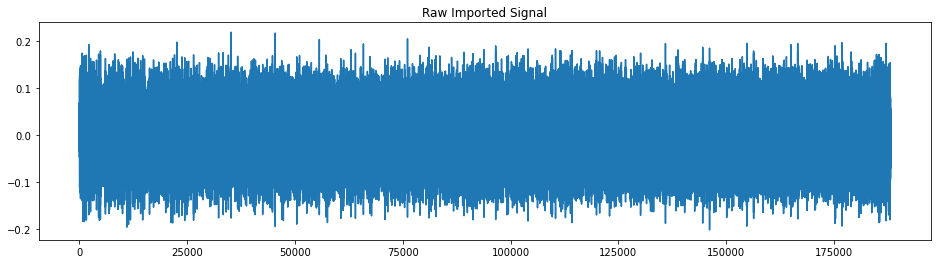

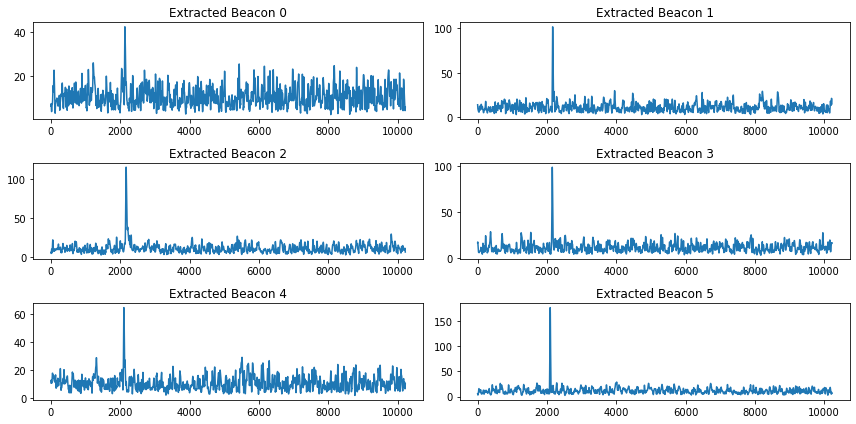

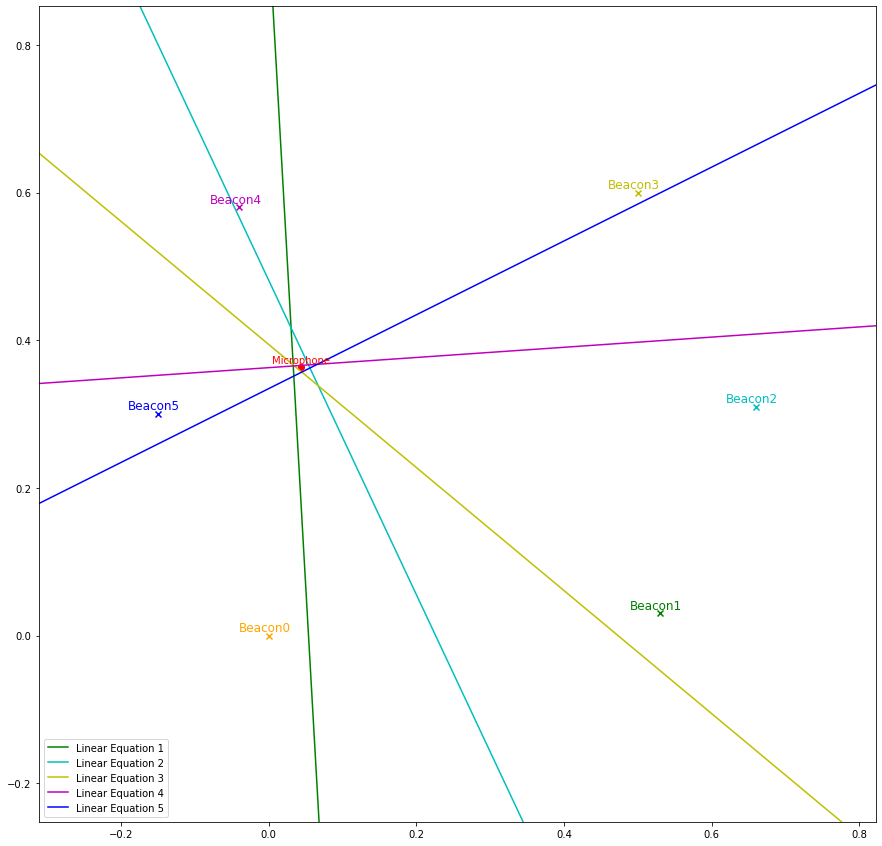

In [27]:
Lab = APS('new_data.npy', [0, 40], ms= True)
Lab.simulation_testing('APS_Recording/test-signal.wav', construct_system, least_squares)

<a id='task4'></a>
# <span style="color:blue">Task 4: Real Life Positioning </span>

Now we are ready to determine speaker position in lab! 
Ask a TA or ASE to help you with obtaining a recording. Your recording will be uploaded to [this folder](https://drive.google.com/drive/folders/1rvMaBNMfOGDazpV2bjgQUhNwNB9pbM8K?usp=sharing). Navigate to your lab section's folder, and download your `.wav` file and move it to the same directory as this notebook.

Run the cells below to see if your code can determine where you had placed your speaker.

Type filename (including the .wav): APS_Class_Sim.wav


KeyboardInterrupt: 

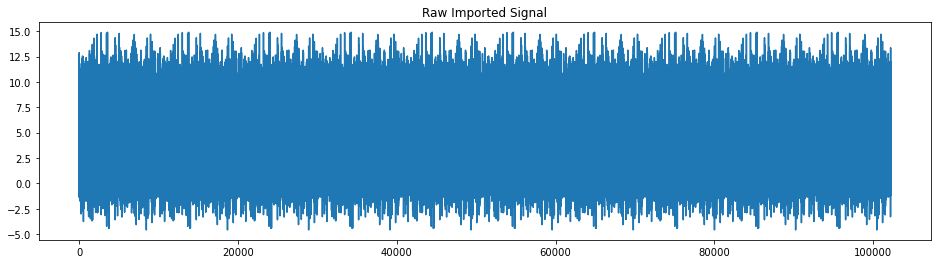

In [28]:
Lab = APS('new_data.npy', [0, 40], ms= True)
user_test(Lab, construct_system, least_squares)

## **Congratulations!**
You have successfully located a microphone using techniques such as cross-correlation, multilateration and least squares.

Kudos for making it through the lab component of EECS16A. We hope you had a great time. Good luck for the rest of your journey through EECS. Bon voyage!

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off,
1. Fill out the checkoff google form. **[Checkoff Form](https://docs.google.com/forms/d/e/1FAIpQLSeq9w_gvQKS37hUXgTDtiYhu9gNmu5OFzglIYAF4nfXQc5mOA/viewform?usp=sf_link)**
2. Submit a **checkoff** request on the lab queue. **[Checkoff queue](https://lab.eecs16a.org)** It is fine if only one person from your group submits the lab queue request, but everyone must submit their own google form. 

Your GSI or a Lab Assistant will join your breakout room when they are available and go through some checkoff questions with your group. They will go through the checkoff list in order. Please be patient!

## **<span style="color:red"> Please have your notebook ready to demo before being checked off. </span>**